## Importing libraries

In [1]:
%load_ext autoreload
%autoreload 2

import gymnasium as gym
import pde_control_gym
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import stable_baselines3
import time
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

## Initializing Gym

In [2]:
T = 240
dt = 0.25
dx = 10
X = 500

from pde_control_gym.src import TrafficARZReward
reward_class =  TrafficARZReward()

Parameters = {
        "T": T, 
        "dt": dt, 
        "X": X,
        "dx": dx, 
        "reward_class": reward_class,
        "simulation_type" : 'outlet-train', 
        "v_steady" : 10,
        "ro_steady" : 0.12,
        "v_max" : 40,
        "ro_max" : 0.16,
        "tau" : 60, 
        "limit_pde_state_size" : True
        # "control_freq" : 6,
        # "reward_buffer_size" : 60
}



In [3]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class NanCheckerCallback(BaseCallback):
    def _on_step(self) -> bool:
        new_obs = self.locals.get('new_obs', None)
        rewards = self.locals.get('rewards', None)

        if new_obs is not None and np.any(np.isnan(new_obs)):
            print("NaN in observation!")
            return False
        if rewards is not None and np.any(np.isnan(rewards)):
            print("NaN in reward!")
            return False

        return True


In [4]:
# Parameters["simulation_type"] = 'outlet-train'
envRL = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
vec_env = DummyVecEnv([lambda: envRL])
vec_env_norm = VecNormalize(vec_env, norm_obs=True, norm_reward=False)

checkpoint_callback = CheckpointCallback(
  save_freq=25000,
  save_path="./logsPPO",
  name_prefix="rl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

from stable_baselines3.common.callbacks import BaseCallback

class RewardLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)

    def _on_step(self):
        # Log the rewards at each step to TensorBoard
        self.logger.record('reward', np.mean(self.locals['rewards']))
        return True

# Use this callback alongside other callbacks
reward_logging_callback = RewardLoggingCallback()
nan_check = NanCheckerCallback()

from stable_baselines3.common.callbacks import CallbackList
callback_list = CallbackList([checkpoint_callback,reward_logging_callback])

# model = PPO("MlpPolicy",
#             vec_env_norm,
#             verbose=1,
#             tensorboard_log="./tb/",
#             learning_rate=8.0e-4,
#             n_steps=480,        
#             batch_size=80,      
#             n_epochs=4,        
#             gamma=0.99,
#             gae_lambda=0.95,
#             clip_range=0.1,
#             ent_coef=0.001,
#             vf_coef=0.1,
#             max_grad_norm=0.5,
#             policy_kwargs=dict(net_arch=dict(pi=[64, 64], vf=[64, 64]))
#             )

model = PPO("MlpPolicy",envRL, verbose=1, tensorboard_log="./tb/")
model.learn(total_timesteps=500000, callback=callback_list)

Case 5: Outlet training
0.12 10.0
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Resetting env 0.115 11.25
Logging to ./tb/PPO_2
Resetting env 0.115 11.25


c:\Users\gokul\miniconda3\envs\PDE\lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Resetting env 0.115 11.25
Resetting env 0.115 11.25
Resetting env 0.12 10.0
Resetting env 0.115 11.25
Resetting env 0.115 11.25
Resetting env 0.12 10.0
Resetting env 0.115 11.25
Resetting env 0.125 8.75
Resetting env 0.125 8.75
Resetting env 0.115 11.25
-----------------------------------
| reward             | -2.6490345 |
| rollout/           |            |
|    ep_len_mean     | 472        |
|    ep_rew_mean     | -828       |
| time/              |            |
|    fps             | 986        |
|    iterations      | 1          |
|    time_elapsed    | 2          |
|    total_timesteps | 2048       |
-----------------------------------
Resetting env 0.12 10.0
Resetting env 0.115 11.25
Resetting env 0.115 11.25
Resetting env 0.115 11.25
Resetting env 0.12 10.0
Resetting env 0.125 8.75
Resetting env 0.125 8.75
Resetting env 0.115 11.25
Resetting env 0.115 11.25
Resetting env 0.115 11.25
Resetting env 0.12 10.0
-----------------------------------------
| reward                  | -1

In [3]:
def runSingleEpisode(model, env, parameter = None):
    terminate = False
    truncate = False

    # Holds the resulting states 
    uStorage = []

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    ns = 0
    i = 0
    rew = 0
    act_h = []
    rew_h = []
    while not truncate and not terminate:
        # use backstepping controller
        action = model(env,obs,parameter)
        act_h.append(action)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs)
        rew += rewards
        rew_h.append(rewards)
        ns += 1
        # print(ns)
    u = np.array(uStorage)
    return rew, u, act_h, rew_h


def RLController(env,obs,model):
    # Assume a is the flattened concatenation of self.r and self.v
    half = obs.shape[0] // 2
    
    # Recover self.r and self.v
    r = obs[:half]
    v = obs[half:]
    
    # Compute b
    obs_sc = np.reshape(
        np.concatenate(((r - env.unwrapped.rs) / env.unwrapped.rs, (v - env.unwrapped.vs) / env.unwrapped.vs)),
        -1
    )

    action, _state = model.predict(obs_sc)
    return action

## testing


In [4]:
Parameters["simulation_type"] = 'outlet'
PPO_model = PPO.load('./logsPPO/rl_model_500000_steps.zip')
envBcks = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
rewBcksTen, uBcksTen, act_h, rew_h = runSingleEpisode(RLController, envBcks,PPO_model )

Case 1: Outlet Boundary Control
0.12 10
Resetting env 0.12 10


C:\Users\gokul\miniconda3\envs\PDE\lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
C:\Users\gokul\miniconda3\envs\PDE\lib\site-packages\gymnasium\utils\passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [ ]:
# Scale density
uBcksTen[:, :50] *= 1000

# Common spatial & temporal grids
spatial = np.linspace(0, X, int(round(X/dx)))
temporal = np.linspace(0, T, uBcksTen.shape[0])
meshx, mesht = np.meshgrid(spatial, temporal)

# Create side-by-side 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot density r(x, t)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(meshx, mesht, uBcksTen[:, :50],
                 edgecolor="black", lw=0.2,
                 rstride=5, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax1.set_title("Density r(x, t)")
ax1.set_xlabel("Length x")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Density")

# Plot velocity v(x, t)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(meshx, mesht, uBcksTen[:, 52:],
                 edgecolor="black", lw=0.2,
                 rstride=5, cstride=100,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax2.set_title("Velocity v(x, t)")
ax2.set_xlabel("Length x")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Velocity")

# Set side view for both plots
ax1.view_init(elev=20, azim=10)
ax2.view_init(elev=20, azim=10)


plt.tight_layout()
plt.show()

In [ ]:
plt.plot(act_h)

In [ ]:
plt.plot(rew_h)

In [7]:
sum(rew_h[-100:])/100

np.float64(-0.04321784681610577)

In [9]:
len(rew_h)

3840

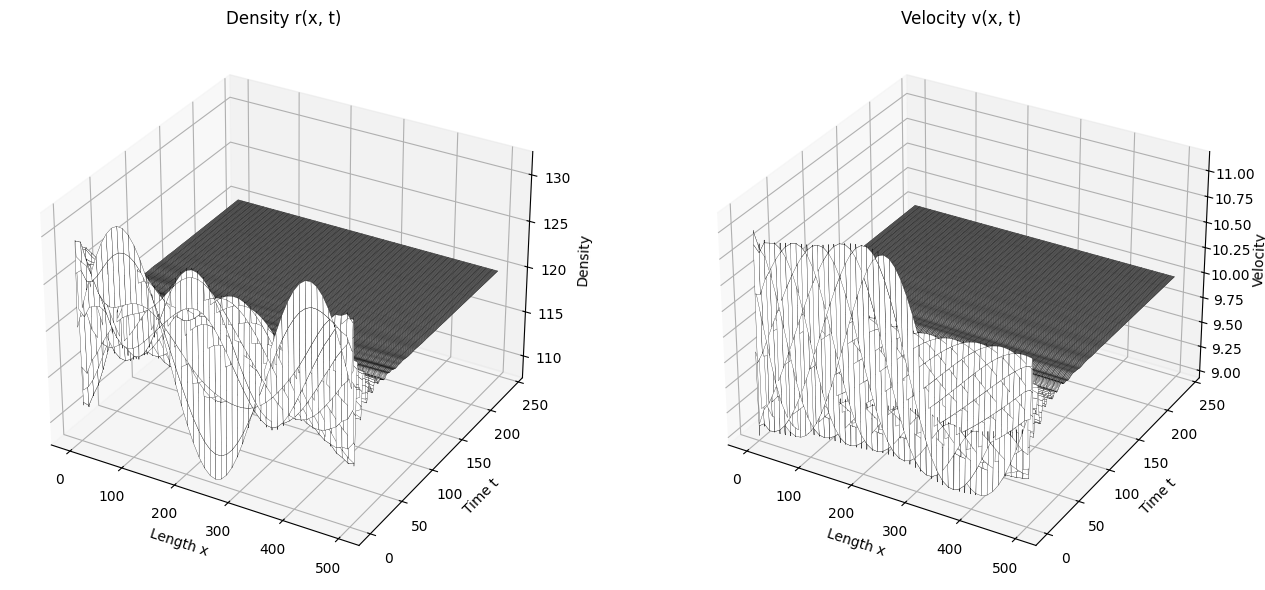

In [20]:
# Scale density
uBcksTen[:, :50] *= 1000

# Common spatial & temporal grids
spatial = np.linspace(0, X, int(round(X/dx)))
temporal = np.linspace(0, T, uBcksTen.shape[0])
meshx, mesht = np.meshgrid(spatial, temporal)

# Create side-by-side 3D plots
fig = plt.figure(figsize=(14, 6))

# Plot density r(x, t)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(meshx, mesht, uBcksTen[:, :50],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax1.set_title("Density r(x, t)")
ax1.set_xlabel("Length x")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Density")

# Plot velocity v(x, t)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(meshx, mesht, uBcksTen[:, 52:],
                 edgecolor="black", lw=0.2,
                 rstride=10, cstride=1,
                 alpha=1, color="white",
                 shade=False, rasterized=True,
                 antialiased=True)
ax2.set_title("Velocity v(x, t)")
ax2.set_xlabel("Length x")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Velocity")

plt.tight_layout()
plt.show()

In [ ]:
env = gym.make("PDEControlGym-TrafficPDE1D",**Parameters)
obs, _ = env.reset()
for _ in range(50):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    if done or truncated:
        env.reset()
    print(f"Reward: {reward}, Done: {done}, Truncated: {truncated}")